<a href="https://colab.research.google.com/github/karjain/Anti_deepFake/blob/main/Xcep2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive

Mounted at /content/drive
/content/drive


In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
#import tensorflow_hub as hub

import os
import argparse
from os.path import join
import cv2
import dlib
#import torch
#import torch.nn as nn
from PIL import Image as pil_image
from tqdm import tqdm

####Run only of you want to optimize  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1
1e-05 5.9807360000000024e-05


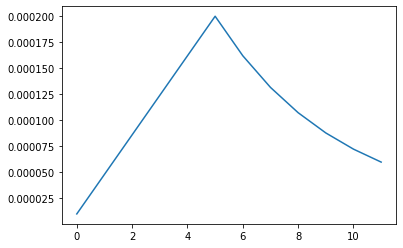

In [ ]:

EPOCHS = 12
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
#IMAGE_SHAPE = (224, 224)
IMAGE_SHAPE = (112, 112)
pretrained_model = tf.keras.applications.Xception(input_shape=IMAGE_SHAPE+(3,),include_top=False, weights= 'imagenet')
pretrained_model.trainable = True
classifier = tf.keras.Sequential([
    pretrained_model,
    #hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32) 
])

classifier.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
)

In [ ]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


### Dataset

 

In [ ]:
!ls "/content/drive/My Drive/Fake_dect/Trial_Dataset"

fake  real  test


Let's load this data into our model using  images off disk using image_dataset_from_directory.

In [ ]:
#batch_size = 32
img_height = 112
img_width = 112
 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  #str('/content/drive/My Drive/Fake_dect/Trial_Dataset'),
  str('/content/drive/MyDrive/Fake_dect/merged_data'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)
 
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  #str('/content/drive/My Drive/Fake_dect/Trial_Dataset'),
  str('/content/drive/MyDrive/Fake_dect/merged_data'),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 19207 files belonging to 2 classes.
Using 15366 files for training.
Found 19207 files belonging to 2 classes.
Using 3841 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
class_names_v = np.array(valid_ds.class_names)
print(class_names), print(class_names_v)

['fake' 'real']
['fake' 'real']


(None, None)

Note: you could also include the `Rescaling` layer inside the model. See this [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers) for a discussion of the tradeoffs.

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
train_ds = train_ds.map(lambda x, y: (flip_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (flip_layer(x), y))

contrast_layer = tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(0,2))
train_ds = train_ds.map(lambda x, y: (contrast_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (contrast_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 112, 112, 3)
(16,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<tf.Tensor: shape=(), dtype=int32, numpy=0>

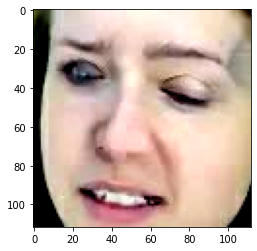

In [ ]:
plt.imshow(image_batch[0])
labels_batch[0]

### Run the classifier on a batch of images

In [ ]:
start_time = time.time()
history = classifier.fit(train_ds, validation_data=valid_ds, epochs=8, verbose = True, callbacks=[lr_callback])


final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", (time.time() - start_time)/60, " mins")


Epoch 1/8

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
961/961 [==============================] - 6078s 6s/step - loss: 0.3602 - accuracy: 0.9034 - val_loss: 0.2442 - val_accuracy: 0.9649
Epoch 2/8

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
961/961 [==============================] - 84s 87ms/step - loss: 0.0691 - accuracy: 0.9684 - val_loss: 0.0453 - val_accuracy: 0.9766
Epoch 3/8

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
961/961 [==============================] - 84s 87ms/step - loss: 0.0362 - accuracy: 0.9853 - val_loss: 0.1827 - val_accuracy: 0.9831
Epoch 4/8

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
961/961 [==============================] - 84s 88ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0872 - val_accuracy: 0.9800
Epoch 5/8

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
961/961 [==============================] - 84s 88ms/step - loss

In [ ]:
classifier.save('/content/drive/MyDrive/Fake_dect/Kmodel_deep_foren.h5')

# New Section

In [ ]:
history.history["val_accuracy"]

[0.8140243887901306,
 0.9192073345184326,
 0.9329268336296082,
 0.9131097793579102,
 0.8628048896789551,
 0.9496951103210449,
 0.9664633870124817,
 0.9664633870124817]

In [ ]:
result_batch = classifier.predict(train_ds)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


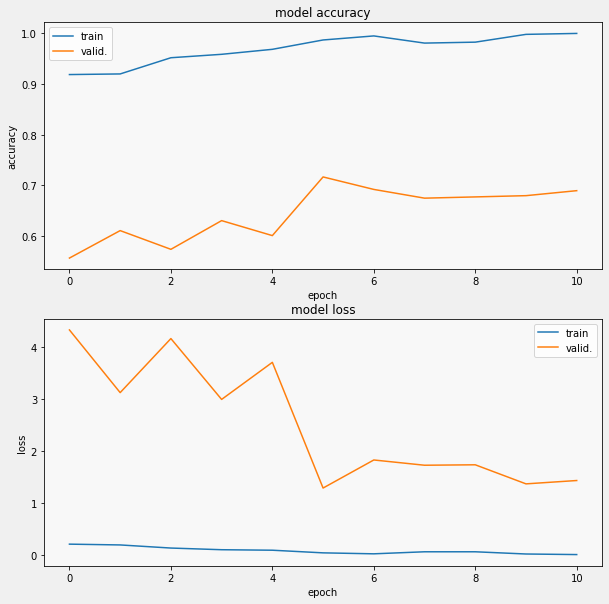

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout() # bug in tight layout in this version of matplotlib
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

Saving the model

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()